\begin{equation*}
\newcommand{\E}{\mathbb{E}}
\newcommand{\Nor}{\mathcal{N}}
\end{equation*}




# Due Dates

* Textbook: Thursday, October 25, in class
* Coding: Thursday, October 25, at 11:59 PM

# Textbook Problems

* 3.7
* 3.26
* 3.28 (Don't try to compare with Ackermann's formula / pole placement, since we have not discussed this.) 
* 3.31



In [6]:
# This is code to load the assignment.
# You'll need to run this code do or restart the assignment.
from loadAssignment import loadAssignment
Assignment, Questions, Submit, Data = loadAssignment(5)

# These are modules that we need
# once you run this code, you don't need to load them again
import autograd.numpy as np
import autograd as ag
import scipy.linalg as la
import matplotlib.pyplot as plt
%matplotlib inline




# Question 0





In this homework, we will use the extended Kalman filter to track the movement of a simple 
vehicle model given in discrete-time by:
\begin{equation*}
\begin{bmatrix}
p_x[k+1] \\
p_y[k+1] \\
\theta[k+1]
\end{bmatrix}
=
\begin{bmatrix}
p_x[k] \\
p_y[k] \\
\theta[k]
\end{bmatrix} + dt 
\begin{bmatrix}
u_v[k] \cos(\theta[k]) \\ 
u_v[k] \sin(\theta[k]) \\
u_\omega[k]
\end{bmatrix}
+w[k].
\end{equation*}




Here $dt$ is the time-step and $w[k]$ is the process noise. We will assume that $dt=0.1$ and the process noise is independent Gaussian noise distributed as $w[k] \sim\Nor(0,0.0001I)$.

We stack the state and inputs as:
\begin{equation*}
x[k] = \begin{bmatrix}
p_x[k] \\
p_y[k] \\
\theta[k]
\end{bmatrix}
\quad 
u[k] = \begin{bmatrix}
u_v[k] \\
u_\omega[k]
\end{bmatrix}
\end{equation*}

The initial condition, control input, $u[0],\ldots,u[488]$, and noise terms $w[0],\ldots,w[488]$ are given below. 



In [7]:
x0 = Data.x0
U = Data.U
Wp = Data.Wp



Simulate the system. Store your result in a matrix of size $3\times 490$, where each row corresponds to a state value. 



In [8]:
# Store your result in an array called X
list=[(x0)]
temp=(x0)
for k in range(489):
    temp=temp+([0.1*U[k][0]*np.cos(temp[2]),0.1*U[k][0]*np.sin(temp[2]),0.1*U[k][1]])+(Wp[k])
    list.append(temp)
X=np.array(list)
print(Wp)
Questions[0].checkAnswer(X)

[[ 1.03000965e-03 -4.81457392e-03 -2.07396783e-02]
 [ 4.41044610e-03 -1.87980303e-02  1.19603871e-02]
 [ 1.19397551e-02  5.91593715e-06 -5.81531492e-03]
 ...
 [-5.96176296e-03 -4.41270042e-03  2.24167321e-03]
 [-2.40802942e-05 -1.01702824e-03  1.21720835e-02]
 [-6.54847526e-03 -7.64063397e-03  1.73171763e-02]]
That is correct. Nice.
A score of 1 was entered for Question 0


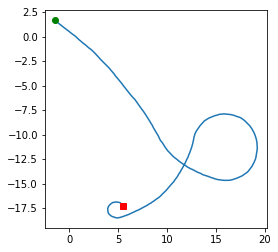

In [9]:
# Here is the true trajectory of the vehicle
plt.plot(X[:,0],X[:,1])
plt.plot(X[0,0],X[0,1],'go')
plt.plot(X[-1,0],X[-1,1],'rs')
plt.gca().set_aspect('equal')


# Question 1

In the next several problems, we will code up the extended Kalman filter (EKF) for this problem.

The course text does not cover the discrete-time EKF. A good alternative reference that does cover the discrete-time EKF is given here:

https://users.aalto.fi/~ssarkka/pub/cup_book_online_20131111.pdf


The discussion is in Section 5.2. Specifically, we will use Algorithm 5.5.  

This question will focus on the time-update.

Assume that we have computed our posterior approximations:
\begin{equation*}
\hat x_k^+ = \E[x_k | y_{0:k},u_{0:k-1}], \quad P_k^+ = \E[(x_k-\hat x_k^+)(x_k-\hat x_k^+)^\top]
\end{equation*}

Given the input $u_k$ calculate the EKF approximation to the mean can covariance:
\begin{equation*}
\hat x_{k+1}^- = \E[x_{k+1} | y_{0:k},u_{0:k}], \quad 
P_{k+1}^- = \E[(x_{k+1}-\hat x_{k+1}^-)(x_{k+1}-\hat x_{k+1}^-)^\top]
\end{equation*}

Specifically, write a function of the form:

```
x_pre,P_pre = carTimeUpdate(x_post,P_post,u)
```

As always, I would encourage you to use autograd, rather than taking the required Jacobians manually.



In [14]:
# Define your function here
dt=0.1

def dot(*arg):
    Answer=arg[0]
    for i in range(len(arg)-1):
        Answer= np.dot(Answer,arg[i+1])
    return Answer

def carTimeUpdate(x_post,P_post,u):
    def fun(xk,wk):
        return np.array([xk[0]+dt*u[0]*np.cos(xk[2])+wk[0],xk[1]+dt*u[0]*np.sin(xk[2])+wk[1],xk[2]+dt*u[1]+wk[2]])
    
    x_pre=fun(x_post,np.zeros(len(x_post)))
    dx = ag.jacobian(fun,argnum=0)
    dq= ag.jacobian(fun,argnum=1)
    Fx=dx(x_post,np.zeros(len(x_post)))
    Fq=dq(x_post,np.zeros(len(x_post)))
    Qk=0.0001*np.eye(len(x_pre))
    P_pre=dot(Fx,P_post,np.transpose(Fx))+dot(Fq,Qk,np.transpose(Fq))
    return x_pre,P_pre
Questions[1].checkAnswer(carTimeUpdate)

Huzzah.
A score of 1 was entered for Question 1



# Question 2

Recall the distance measurement model from a few weeks ago:

\begin{equation*}
(y_k)_i = \|p_k-c_i\| + 0.2 (1+\|x-c_i\|) (v_k)_i
\end{equation*}

Here $p_k = \begin{bmatrix} p_x[k] \\ p_y[k] \end{bmatrix}$, $c_i$ corresponds to the location of a sensor, and $(v_k)_i$ are independent Gaussian noises with mean $0$ and covariance $1$. The term $(y_k)_i$ denotes that entry $i$ of the measurement at time $k$. Similarly, $(v_k)_i$ is the entry $i$ of the measurement noise at time $k$. 
In this problem, we will have $10$ sensors at locations given below:



In [15]:
SensorLocs = Data.SensorLocs


Assume now that the prior approximations have been computed:

\begin{equation*}
\hat x_k^- = \E[x_k | y_{0:k-1},u_{0:k-1}], \quad P_k^- = \E[(x_k - \hat x_k^-)(x_k - \hat x_k^-)^\top]
\end{equation*}

Given the measurement, $y_k$, compute the EKF posterior approximations:

\begin{equation*}
\hat x_k^+ = \E[x_k | y_{0:k},u_{0:k-1}], \quad P_k^+ = \E[(x_k-\hat x_k^+)(x_k - \hat x_k^+)^\top].
\end{equation*}

Specifically, write a function of the form:

```
x_post,P_post = carMeasUpdate(x_pre,P_pre,y)
```



In [58]:
# Define your function here
def carMeasUpdate(x_pre,P_pre,y):
    def h(Pk,vk):
        f2=np.array([Pk[0],Pk[1]])
        error=np.outer(np.ones(len(SensorLocs)),np.array([Pk[0],Pk[1]])) - SensorLocs
        return np.linalg.norm(error,axis=1)+0.2*(1+np.linalg.norm(error,axis=1))*vk
    
    dhx = ag.jacobian(h,argnum=0)
    dhR= ag.jacobian(h,argnum=1)
    Hx=dhx(x_pre,np.zeros(10))
    HR=dhR(x_pre,np.zeros(10))
    
    k_plus=y-h(x_pre,np.zeros(10))
    Sk=mult(Hx,P_pre,np.transpose(Hx))+mult(HR,np.transpose(HR))

    Kk=mult(P_pre,np.transpose(Hx),np.linalg.inv(Sk))
    x_post=x_pre+mult(Kk,k_plus)

    
    P_post=P_pre-mult(Kk,Sk,np.transpose(Kk))
    return x_post,P_post
    


Questions[2].checkAnswer(carMeasUpdate)

Huzzah.
A score of 1 was entered for Question 2





# Question 3

Now we will use the functions above to compute the EKF for the vehicle model. So, we will assume that the vehicle state is no longer directly measured. Assume that the initial state is distributed as $\Nor(0,10\cdot I)$. Furthermore, assume that the measurements are those given below:



In [59]:
Y = Data.Y


In particular, make a $490\times 3$ array for the values of $\hat x_k^+$ and an $490 \times 3\times 3$ array for the values of $P_k^+$. 



In [60]:
# Calculate the estimates here
# Call them Mu and P_arr
Mu=np.zeros((490,3))
P_kplus=np.zeros((490,3,3))

mu=np.zeros(3)
sigma=10*np.eye(3)
Mu[0,:],P_kplus[0,:,:]=carMeasUpdate(mu,sigma,Y[0])


for k in range(1,490):
        x_pre,P_pre=carTimeUpdate(Mu[k-1,:],P_kplus[k-1,:,:],U[k-1]);
        Mu[k,:],P_kplus[k,:,:]=carMeasUpdate(x_pre,P_pre,Y[k]); 
Questions[3].checkAnswer(Mu,P_kplus)

True - Test:
[[-4.16333634e-17  1.55431223e-15  0.00000000e+00]
 [ 2.44249065e-15  6.88338275e-15  0.00000000e+00]
 [ 3.33066907e-15  5.10702591e-15  0.00000000e+00]
 ...
 [ 2.66453526e-15  0.00000000e+00  4.44089210e-16]
 [ 2.66453526e-15  0.00000000e+00  4.44089210e-16]
 [ 2.66453526e-15  0.00000000e+00  4.44089210e-16]]
Passed
True - Test:
[[[ 1.77635684e-15 -3.55271368e-15  0.00000000e+00]
  [-5.32907052e-15 -7.10542736e-15  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]

 [[ 4.44089210e-16 -1.66533454e-15  0.00000000e+00]
  [-3.33066907e-15 -1.88737914e-15  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]

 [[ 2.22044605e-16 -1.33226763e-15  0.00000000e+00]
  [-2.83106871e-15 -2.77555756e-16  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]

 ...

 [[-1.24900090e-16 -2.98372438e-16  5.29090660e-17]
  [ 6.97358837e-16  3.53883589e-16  1.13624388e-16]
  [-7.93635990e-17 -5.89805982e-17 -5.20417043e-18]]

 [[-1.38777878e-1


# Question 4

Plot your estimates. Specifically, make $3\times 1$ collection of subplots. Assume that time starts at $0$ and the system has a sampling interval of $0.1$. Each subplot should show the corresponding state and estimate plotted with respect to time. 
For the angle, $\theta$, the values should be shifted to lie in $[-\pi,\pi)$. 



Incorrect
You may, however, try again.
A score of 0 was entered for Question 4


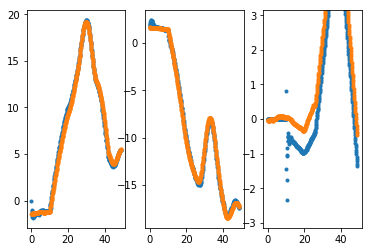

In [61]:
# Make your plots here.
import matplotlib.pyplot
time=np.linspace(0,48.9,num=490)
plt.subplot(1,3,1)
plt.plot(time,Mu[:,0],'.')
plt.plot(time,X[:,0],'.')
plt.subplot(1,3,2)
plt.plot(time,Mu[:,1],'.')
plt.plot(time,X[:,1],'.')
plt.subplot(1,3,3)
plt.plot(time,Mu[:,2],'.')
plt.plot(time,X[:,2]+7,'.')
matplotlib.pyplot.ylim(-3.14,3.14)
Questions[4].checkAnswer()


# Final Score

You can run this code to see all of your scores.




In [62]:
Assignment.showResults()

Problem 0: 1
Problem 1: 1
Problem 2: 1
Problem 3: 1
Problem 4: 0

Total: 4 / 5





# Submission

Save your work and run this cell to submit. It will only work if you have the internet.



In [ ]:
Submit()